# Subsurface Visualization

**Author:** Hasan Shojaei (hasan.shojaei@gmail.com)

We are given a dataset including 3 files: 

- WellLogs.csv which includes petro-physical well logs. Each zone (formation) is identified with a label.
- Formations.csv which includes top and bottom MDs of each zone.
- FormationContributions.csv which includes an estimate of how much each zone contributes to produced fluid 

Our goal is to visualize the subsurface along the depth to help inform field development decisions. 


## Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Reading in the Data

In [2]:
WellLogs = pd.read_csv("WellLogs.csv")

In [3]:
Formations = pd.read_csv("Formations.csv", index_col=0)

In [4]:
FormContrib = pd.read_csv("FormationContributions.csv", index_col=0)

## Pre-Processing the Data

In [5]:
# Convert Zone to a Categorical variable
WellLogs['Zone'] = pd.Categorical(WellLogs['Zone'])

In [6]:
# Calculate brittleness index
WellLogs['BrittlenessIndex'] = (WellLogs.VQTZ+WellLogs.VCALC)/(WellLogs.VQTZ+WellLogs.VCALC+WellLogs.VCL+WellLogs.VKER+WellLogs.VOIL+WellLogs.VPYR)

In [7]:
WellLogs['VWAT'] = WellLogs['SWT']*WellLogs['PHIT']

In [8]:
# Calculate average properties for each zone
AvgProp = WellLogs.groupby('Zone').mean().copy()

## Visualizing the Data

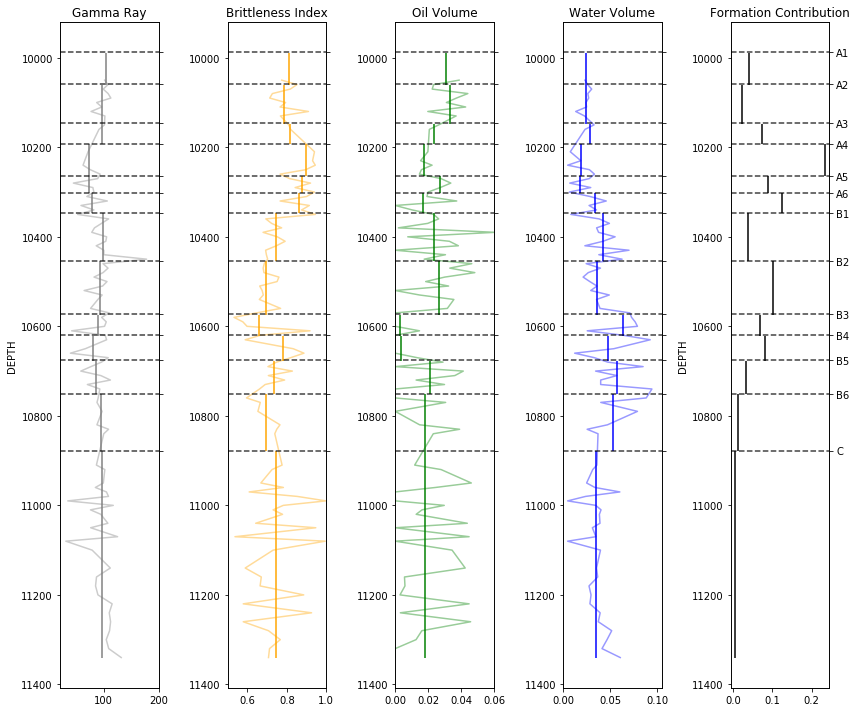

In [9]:
log_names = ['GR', 'BrittlenessIndex', 'VOIL', 'VWAT']
log_colors = ['grey', 'orange', 'g', 'b']
log_titles = ['Gamma Ray', 'Brittleness Index', 'Oil Volume', 'Water Volume']
log_xlim = [(20, 200), (0.5, 1), (0, 0.06), (0, 0.105)]

fig, axes = plt.subplots(1,5, figsize=(12,10))
axes = axes.ravel()

for i in range(len(log_names)):
    
    axes[i].plot(WellLogs[log_names[i]], WellLogs['MD'], c=log_colors[i], alpha=0.4)       
    for j, r in AvgProp.iterrows():
        axes[i].vlines(x=r[log_names[i]], ymin=Formations.BottomMD[j], 
                       ymax=Formations.TopMD[j], color=log_colors[i])
    axes[i].invert_yaxis()
    if i==0:
        axes[i].set(ylabel='DEPTH', title=log_titles[i])
    else:
        axes[i].set(title=log_titles[i])
    axes[i].set_xlim(log_xlim[i][0], log_xlim[i][1])


for i, r in FormContrib.iterrows():
    axes[4].vlines(x=r['RelativeContribution'], ymin=Formations.BottomMD[i], ymax=Formations.TopMD[i], color="k")
    axes[4].set_ylim(axes[3].get_ylim())
    axes[4].set(ylabel='DEPTH', title='Formation Contribution')
    

## Add in formation tops using a 2nd axis for both plots
for j in range(0,5):
    ax2 = axes[j].twinx() 
    ax2.set_ylim(axes[j].get_ylim())
    ytick, ylabel = [], []

    # Code for adding in formation dashed lines and labels
    for i, r in Formations.iterrows():
        ax2.axhline(r['TopMD'] - 0.5, ls='--', color='k', alpha=0.75)
        ytick.append(r['TopMD'] - 0.5)
        if j==4: ylabel.append(i)
        ax2.set(yticks=ytick, yticklabels=ylabel)


fig.tight_layout()
# fig.savefig('LogTracks.png', dpi=300, bbox_inches='tight')

**Thoughts:**
- Zones A4-A6 have high brittleness values, which will increase hydraulic fracture efficiency in those zones. They also provide large production contributions according to the Formation Contribution log. 
- Zones B3 and B4 have very low oil contents but the Formation Contribution log suggests they're contributing significantly to liquid production. Therefore B3 and B4 are likely soucres of water production for this well. 
- In general Brittleness Index shows a good correlation with formation contribution estimate. 